In [10]:
print("test  ##aru50")

test  ##aru50


In [11]:
from oggm import cfg, utils, workflow, graphics, tasks, DEFAULT_BASE_URL
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from oggm import cfg, utils, workflow, tasks
from oggm.core import gis
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
import os
from oggm.core import inversion
import salem
import xarray as xr
import glob
import os

In [12]:
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['mp_processes'] = 12
cfg.PARAMS['border'] = 10
cfg.PARAMS['use_rgi_area'] = True
# Intersects dont work for now
# cfg.PARAMS['use_intersects'] = False
# # 初始化
cfg.PATHS['working_dir'] = '/mnt/d/lidar/ali/area/same_boundary'
cfg.PARAMS['use_intersects'] = False

#######计算厚度的剪切应力
cfg.PARAMS['ice_thick_param'] = 1.8e6
cfg.PARAMS['inversion_shape_factor'] = 0.65
cfg.PARAMS['glen_a'] *= 1.5
# 试验1：放大融化因子
# cfg.PARAMS['melt_f'] *= 1.1  # 或在局部 gdir 的校准字典里修改 melt_f
# 或试验2：调暖温度偏置
# 读取 Shapefile
gdf = gpd.read_file('/mnt/d/lidar/ali/area/same_boundary/aru50_af_2020.shp')
#gdf = gdf[gdf.geometry.is_valid & ~gdf.geometry.is_empty]

# 投影转换
# gdf = gdf.to_crs("EPSG:4326")


custom_gdf = utils.cook_rgidf(gdf, o1_region='13')
custom_gdf['RGIId'] = ["RGI60-13.51476"]
custom_gdf['Area'] = 4.057646

gdirs = workflow.init_glacier_directories(gdf, reset=True, force=True)

# We start from prepro level 3 with all data ready - note the url here
# base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/centerlines/W5E5/'

gdir_cl = gdirs[0]
gdirs

2025-10-13 17:15:11: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.


2025-10-13 17:15:11: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-10-13 17:15:11: oggm.cfg: Multiprocessing: using all available processors (N=24)
2025-10-13 17:15:11: oggm.cfg: Multiprocessing switched ON after user settings.
2025-10-13 17:15:11: oggm.cfg: Multiprocessing: using the requested number of processors (N=12)
2025-10-13 17:15:11: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-10-13 17:15:11: oggm.cfg: PARAMS['use_intersects'] changed from `True` to `False`.
2025-10-13 17:15:11: oggm.cfg: PARAMS['glen_a'] changed from `2.4e-24` to `3.6e-24`.
2025-10-13 17:15:11: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers


[<oggm.GlacierDirectory>
   RGI id: RGI60-13.51476
   Region: 13: Central Asia
   Subregion: 13-08: Inner Tibet                     
   Name: Aru50_Af
   Glacier type: Ice cap
   Terminus type: Land-terminating
   Status: Glacier or ice cap
   Area: 4.046455 km2
   Lon, Lat: (82.26494040819206, 34.003548200742905)]

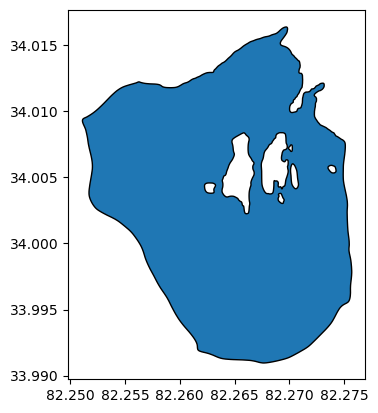

In [13]:
custom_gdf.plot(edgecolor='k');

In [14]:
# dem以及GRID投影
cfg.PATHS['dem_file']="/mnt/d/lidar/dh/z_adj_aline/reproject/test/2/20200103_clip.tif"#20191209_filled_dem.tif"
for gdir in gdirs:
    tasks.define_glacier_region(gdir,source='USER')
    gdir.rgi_date = 2019
    gis.process_dem(gdir)
    tasks.glacier_masks(gdir)

In [15]:
from oggm import workflow, tasks

# 1. 定义区域与基础数据
# workflow.execute_entity_task(tasks.define_glacier_region, gdirs, source='SRTM', reset=True)
workflow.execute_entity_task(tasks.glacier_masks, gdirs, reset=True)
workflow.execute_entity_task(tasks.simple_glacier_masks, gdirs, reset=True)
workflow.execute_entity_task(tasks.elevation_band_flowline, gdirs, reset=True)
workflow.execute_entity_task(tasks.fixed_dx_elevation_band_flowline, gdirs, reset=True)

# # 2. 计算流线与集水区
# workflow.execute_entity_task(tasks.compute_centerlines, gdirs, reset=True)
# workflow.execute_entity_task(tasks.initialize_flowlines, gdirs,reset=True)
# workflow.execute_entity_task(tasks.catchment_area, gdirs,reset=True)
# workflow.execute_entity_task(tasks.catchment_intersections, gdirs,reset=True)
# workflow.execute_entity_task(tasks.catchment_width_geom, gdirs,reset=True)
# workflow.execute_entity_task(tasks.catchment_width_correction, gdirs,reset=True)

# 3. 生成下游拓展流线及床形
workflow.execute_entity_task(tasks.compute_downstream_line, gdirs,reset=True)
workflow.execute_entity_task(tasks.compute_downstream_bedshape, gdirs,reset=True)

# ✅ 4. 【必须】先计算表观质量平衡
workflow.execute_entity_task(tasks.apparent_mb_from_linear_mb, gdirs,reset=True)

# 5. 反演冰厚度
workflow.execute_entity_task(tasks.prepare_for_inversion, gdirs,reset=True)
workflow.execute_entity_task(tasks.mass_conservation_inversion, gdirs,reset=True)


# 6. 平滑并初始化
workflow.execute_entity_task(tasks.filter_inversion_output, gdirs,reset=True)
workflow.execute_entity_task(tasks.process_climate_data, gdirs,reset=True)
workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs,reset=True)
workflow.execute_entity_task(tasks.mb_calibration_from_geodetic_mb, gdirs) #生成mb_calib.json


2025-10-13 17:15:27: oggm.workflow: Execute entity tasks [glacier_masks] on 1 glaciers
2025-10-13 17:15:27: oggm.workflow: Execute entity tasks [simple_glacier_masks] on 1 glaciers
2025-10-13 17:15:27: oggm.workflow: Execute entity tasks [elevation_band_flowline] on 1 glaciers
2025-10-13 17:15:27: oggm.workflow: Execute entity tasks [fixed_dx_elevation_band_flowline] on 1 glaciers
2025-10-13 17:15:27: oggm.workflow: Execute entity tasks [compute_downstream_line] on 1 glaciers
2025-10-13 17:15:27: oggm.workflow: Execute entity tasks [compute_downstream_bedshape] on 1 glaciers
2025-10-13 17:15:27: oggm.workflow: Execute entity tasks [apparent_mb_from_linear_mb] on 1 glaciers
2025-10-13 17:15:27: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2025-10-13 17:15:28: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2025-10-13 17:15:28: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2025-10-13 17:15:28: oggm

[{'rgi_id': 'RGI60-13.51476',
  'bias': 0,
  'melt_f': 6.7096476120319775,
  'prcp_fac': 7.19939099178179,
  'temp_bias': -2.506618047955146,
  'reference_mb': -179.10000000000002,
  'reference_mb_err': 134.3,
  'reference_period': '2000-01-01_2020-01-01',
  'mb_global_params': {'temp_default_gradient': -0.0065,
   'temp_all_solid': 0.0,
   'temp_all_liq': 2.0,
   'temp_melt': -1.0},
  'baseline_climate_source': 'GSWP3_W5E5'}]

In [8]:
fls_cl = gdir_cl.read_pickle('model_flowlines')

Text(0.5, 1.0, 'Geometrical centerline')

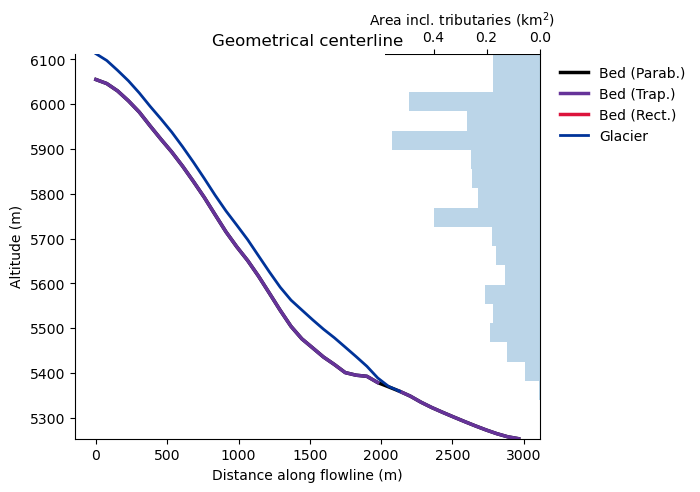

In [9]:
fls_cl = gdir_cl.read_pickle('model_flowlines')
f, ax1= plt.subplots(1, 1, figsize=(6, 5), sharex=True, sharey=True)
graphics.plot_modeloutput_section(fls_cl, ax=ax1)
ax1.set_title('Geometrical centerline')


In [55]:
#############################################
###冰川主流线厚度、基底高度
#############################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取主流线
fls_cl = gdir_cl.read_pickle('model_flowlines')
fl = fls_cl[-1]  # 一般选择最后一条主流线（最长的）

# 提取数据
dist = fl.dis_on_line  # 沿流线距离（单位：米）
bed_h = fl.bed_h       # 床高
surf_h = fl.surface_h  # 冰面高程
thick = fl.thick       # 冰厚
widths = fl.widths_m   # 冰川宽度

# 整理成 DataFrame
df_profile = pd.DataFrame({
    'Distance [m]': dist,
    'Bed elevation [m]': bed_h,
    'Surface elevation [m]': surf_h,
    'Ice thickness [m]': thick,
    'Glacier width [m]': widths
})

# 保存为 Excel 文件
out_path = '/mnt/d/lidar/projection/aru50_centerline_profile.xlsx'
df_profile.to_excel(out_path, index=False)
print(f'保存成功：{out_path}')


保存成功：/mnt/d/lidar/projection/aru50_centerline_profile.xlsx


In [56]:
gdirs = [gdir_cl]

In [57]:
from oggm.shop import gcm_climate

# you can choose one of these 5 different GCMs:
# 'gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1' ("low sensitivity" models, within typical ranges from AR6)
# 'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2' ("hotter" models, especially ukesm1-0-ll)
member = 'mri-esm2-0_r1i1p1f1' 

for ssp in ['ssp126', 'ssp370','ssp585']:
    # bias correct them
    workflow.execute_entity_task(gcm_climate.process_monthly_isimip_data, gdirs, 
                                 ssp = ssp,
                                 # gcm member -> you can choose another one
                                 member=member,
                                 # recognize the climate file for later
                                 output_filesuffix=f'_ISIMIP3b_{member}_{ssp}'
                                 );

2025-10-13 16:12:30: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2025-10-13 16:12:32: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2025-10-13 16:12:34: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers


In [204]:
################################################################
#
#从17年开始
#
# ========== 1. 存储输出 ==========
cfg.PARAMS['store_model_geometry'] = True  
cfg.PARAMS['store_fl_diagnostics'] = True  

# ========== 2. 历史阶段：到2016 ==========
for gdir in gdirs:
    if gdir is gdir_cl:
        cfg.PARAMS['evolution_model'] = 'FluxBased'
    else:
        cfg.PARAMS['evolution_model'] = 'SemiImplicit'

    workflow.execute_entity_task(
        tasks.run_from_climate_data, [gdir],
        ys=1979,          # ✅ 正确参数名：ys（起始年份）
        ye=2016,          # ✅ 正确参数名：ye（结束年份）
        output_filesuffix='_historical'
    )

# ========== 3. 未来阶段：2017年开始预测 ==========
for gdir in gdirs:
    for ssp in ['ssp126', 'ssp370', 'ssp585']:
        rid = f'_ISIMIP3b_{member}_{ssp}'  # 例如 member='r1i1p1f1'

        workflow.execute_entity_task(
            tasks.run_from_climate_data, [gdir],
            climate_filename='gcm_data',
            climate_input_filesuffix=rid,
            init_model_filesuffix='_historical',
            output_filesuffix=f'_ISIMIP3b_{member}_{ssp}',
            ys=2017,          # ✅ 从2017年开始预测
            ye=2100           # 或者 2034，取决于你的目标
        )


2025-10-12 03:01:41: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2025-10-12 03:01:41: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2025-10-12 03:01:41: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2025-10-12 03:01:42: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2025-10-12 03:01:43: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers


In [58]:
# add additional outputs to default OGGM
################################################################
#
#从2020年开始
#
cfg.PARAMS['store_model_geometry'] = True  
cfg.PARAMS['store_fl_diagnostics'] = True

for gdir in gdirs:
    if gdir is gdir_cl:
        cfg.PARAMS['evolution_model'] = 'FluxBased'
    else:
        cfg.PARAMS['evolution_model'] = 'SemiImplicit'

    workflow.execute_entity_task(tasks.run_from_climate_data, [gdir],
                                 output_filesuffix='_historical',  
                                );

    for ssp in ['ssp126', 'ssp370', 'ssp585']:
        rid = f'_ISIMIP3b_{member}_{ssp}'

        workflow.execute_entity_task(tasks.run_from_climate_data, [gdir],
                                     climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                     climate_input_filesuffix=rid,  # use the chosen scenario
                                     init_model_filesuffix='_historical',  # this is important! Start from 2020 glacier
                                     output_filesuffix=rid,  # recognize the run for later
                                    );

2025-10-13 16:12:37: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2025-10-13 16:12:37: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2025-10-13 16:12:38: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2025-10-13 16:12:38: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers


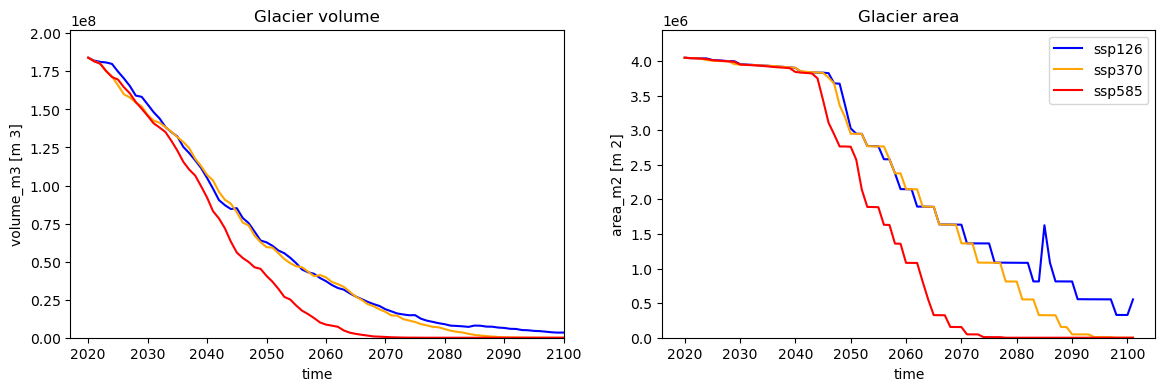

In [59]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Pick some colors for the lines
color_dict={'ssp126':'blue', 'ssp370':'orange', 'ssp585':'red'}

for ssp in ['ssp126','ssp370', 'ssp585']:
    rid = f'_ISIMIP3b_{member}_{ssp}'
    with xr.open_dataset(gdir_cl.get_filepath('model_diagnostics', filesuffix=rid)) as ds:
        ds.volume_m3.plot(ax=ax1, label=ssp, c=color_dict[ssp]);
    ax1.set_title('Glacier volume')
    ax1.set_xlim([2017,2100])
    ax1.set_ylim([0, ds.volume_m3.max().max()*1.1])

for ssp in ['ssp126','ssp370', 'ssp585']:
    rid = f'_ISIMIP3b_{member}_{ssp}'
    with xr.open_dataset(gdir_cl.get_filepath('model_diagnostics', filesuffix=rid)) as ds:
        ds.area_m2.plot(ax=ax2, label=ssp, c=color_dict[ssp]);
    ax2.set_ylim([0, ds.area_m2.max().max()*1.1])
    # ax2.set_xlim([2020,2100])
# for ssp in ['ssp126','ssp370', 'ssp585']:
#     rid = f'_ISIMIP3b_{member}_{ssp}'
#     with xr.open_dataset(gdir_eb.get_filepath('model_diagnostics', filesuffix=rid)) as ds:
#         ds.length_m.plot(ax=ax2, label=ssp, c=color_dict[ssp], ls='--');
    ax2.set_title('Glacier area')
    # ax2.set_xlim([2020,2100])
    
plt.legend();   

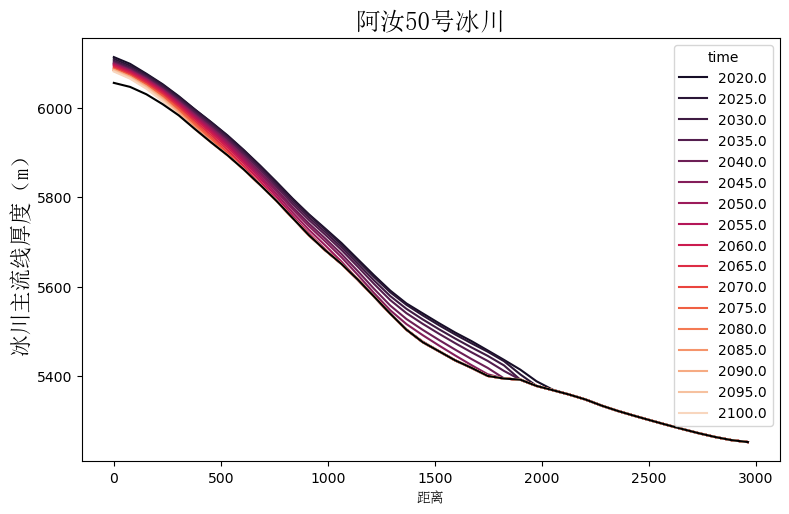

In [60]:
from matplotlib import font_manager as fm


font_path = '/usr/share/fonts/simsun.ttc'
my_font = fm.FontProperties(fname=font_path)

rid = f'_ISIMIP3b_{member}_ssp126'
sel_years = np.linspace(2020, 2100, 17).astype(int)
colors = sns.color_palette('rocket', len(sel_years))
with plt.rc_context({'axes.prop_cycle': plt.cycler(color=colors)}):
    f, ax1= plt.subplots(1, 1, figsize=(9, 5.5), sharey=True, sharex=True)
    n_lines = len(gdir_cl.read_pickle('model_flowlines'))
    with xr.open_dataset(gdir_cl.get_filepath('fl_diagnostics', filesuffix=rid), group=f'fl_{n_lines-1}') as ds:
        (ds.bed_h + ds.sel(time=sel_years).thickness_m).plot(ax=ax1, hue='time')
        ds.bed_h.plot(ax=ax1, c='k')
   
        ax1.set_title('阿汝50号冰川',fontproperties=my_font,fontsize=18)
        ax1.set_ylabel('冰川主流线厚度（m）', fontproperties=my_font,fontsize=16)
        ax1.set_xlabel('距离', fontproperties=my_font)  
    # with xr.open_dataset(gdir_eb.get_filepath('fl_diagnostics', filesuffix=rid), group='fl_0') as ds:
    #     (ds.bed_h + ds.sel(time=sel_years).thickness_m).plot(ax=ax2, hue='time')
    #     ds.bed_h.plot(ax=ax2, c='k')
    #     ax2.set_ylabel('')
    #     ax2.set_title('Elevation bands')

In [61]:
##############################################################
####   将预测的主流线高度分别保存为 xls（ssp126, ssp370, ssp585）
##############################################################
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib
from matplotlib import font_manager as fm
font_path = '/usr/share/fonts/simsun.ttc'
my_font = fm.FontProperties(fname=font_path)

# 选择年份
# sel_years = np.linspace(2020, 2101, 80).astype(int)   # 每5年一个，共17个年份
sel_years = np.arange(2020, 2101, 1).astype(int)

# 情景列表
ssp_list = ['ssp126', 'ssp370', 'ssp585']

# 获取主流线数量
n_lines = len(gdir_cl.read_pickle('model_flowlines'))

for ssp in ssp_list:
    rid = f'_ISIMIP3b_{member}_{ssp}'
    with xr.open_dataset(gdir_cl.get_filepath('fl_diagnostics', filesuffix=rid), group=f'fl_{n_lines-1}') as ds:

        # 提取床高和厚度
        bed_h = ds.bed_h.values
        dist = ds.dis_along_flowline.values
        thick = ds.thickness_m.sel(time=sel_years)
        surface = (thick + ds.bed_h).transpose('time', 'dis_along_flowline')  # 行是年份，列是距离

        # 转为 DataFrame
        df_surface = pd.DataFrame(
            surface.values,
            index=sel_years,
            columns=[f'{int(d)} m' for d in dist]
        )
        df_surface.index.name = 'Year'

        # 输出路径
        out_path = f'/mnt/d/lidar/projection/aru50_thickness_profile_{ssp}.xlsx'
        df_surface.to_excel(out_path)
        print(f'{ssp} 数据保存成功：{out_path}')

ssp126 数据保存成功：/mnt/d/lidar/projection/aru50_thickness_profile_ssp126.xlsx
ssp370 数据保存成功：/mnt/d/lidar/projection/aru50_thickness_profile_ssp370.xlsx
ssp585 数据保存成功：/mnt/d/lidar/projection/aru50_thickness_profile_ssp585.xlsx


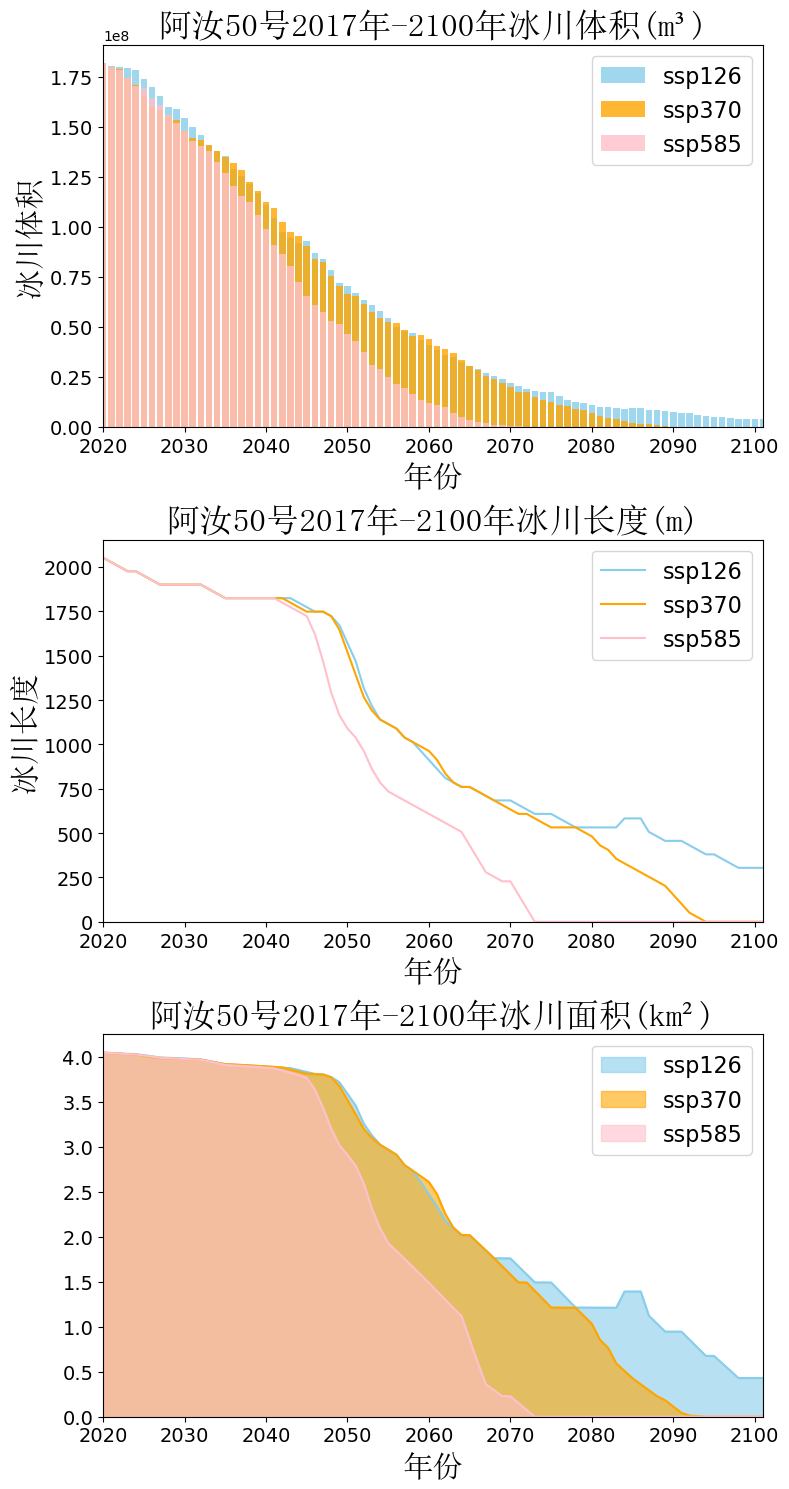

数据成功保存到：/mnt/d/lidar/projection/aru50_glacier_projection.xlsx


In [19]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager as fm


font_path = '/usr/share/fonts/simsun.ttc'
my_font = fm.FontProperties(fname=font_path)

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 15))

color_dict = {'ssp126': 'skyblue', 'ssp370': 'orange', 'ssp585': 'pink'}
smooth_win = 3

# 为柱状图定义偏移和宽度，避免重叠
ssp_list = ['ssp126', 'ssp370', 'ssp585']
bar_width = 0.8
offsets = np.linspace(-bar_width, bar_width, len(ssp_list))  # [-0.25, 0, 0.25]

for i, ssp in enumerate(ssp_list):
    rid = f'_ISIMIP3b_{member}_{ssp}'
    with xr.open_dataset(gdir_cl.get_filepath('model_diagnostics', filesuffix=rid)) as ds:
        vol_smooth = ds.volume_m3.rolling(time=smooth_win, center=True, min_periods=1).mean()
        len_smooth = ds.length_m.rolling(time=smooth_win, center=True, min_periods=1).mean()
        area_smooth = (ds.area_m2 / 1e6).rolling(time=smooth_win, center=True, min_periods=1).mean()

        time = vol_smooth['time'].values
        time_num = np.arange(len(time))
        # 并列柱状图，x轴偏移防止重叠
        ax1.bar(time, ds.volume_m3.values, width=bar_width, alpha=0.8,
                label=ssp, color=color_dict[ssp],align='center')

        # 长度折线图
        ax2.plot(time, len_smooth.values, label=ssp, color=color_dict[ssp])

        # 面积填充图，alpha较低避免叠色过深
        ax3.fill_between(time, 0, area_smooth.values, label=ssp,
                         color=color_dict[ssp], alpha=0.6)
        ax3.plot(time, area_smooth.values, color=color_dict[ssp])

# 设置标题和轴范围
fntsize1=24
fntsize2=22
ax1.set_title('阿汝50号2017年-2100年冰川体积(m³)',fontproperties=my_font, fontsize=fntsize1)
ax1.set_xlabel('年份', fontproperties=my_font,fontsize=fntsize2)   

# ax1.set_xlim(5, len(time ) - 1)
# ax1.set_xticks(np.arange(5, len(time), 10))

time1=time[0::][::10]
# time1=[2025, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]
ax1.set_xlim(time[0], time[-1])
ax1.set_xticks(time1)
ax1.set_xticklabels(time1.astype(int))

ax1.set_ylim(bottom=0)
ax1.set_ylabel('冰川体积', fontproperties=my_font,fontsize=fntsize2)   

ax2.set_title('阿汝50号2017年-2100年冰川长度(m)',fontproperties=my_font,fontsize=fntsize1)
ax2.set_xlabel('年份', fontproperties=my_font,fontsize=fntsize2)      
ax2.set_xlim(time[0], time[-1])
ax2.set_xticks(time1)
ax2.set_xticklabels(time1.astype(int))

ax2.set_ylim(bottom=0)
ax2.set_ylabel('冰川长度',fontproperties=my_font,fontsize=fntsize2)   

ax3.set_title('阿汝50号2017年-2100年冰川面积(km²)',fontproperties=my_font,fontsize=fntsize1)
ax3.set_xlabel('年份', fontproperties=my_font,fontsize=fntsize2)   
ax3.set_xlim(time[0], time[-1])
ax3.set_xticks(time1)
ax3.set_xticklabels(time1.astype(int),fontsize=fntsize2)
ax3.set_ylim(bottom=0)
# ax3.set_ylabel('阿汝50号冰川2025年-2100年面积',fontproperties=my_font,fontsize=fntsize2)   
for ax in (ax1, ax2, ax3):
    ax.tick_params(labelsize=14)  # 刻度字体大小
    ax.legend(loc='upper right', prop={'family': 'Times New Roman', 'size': 16})
# for ax in (ax1, ax2, ax3):
#     ax.legend(loc='upper right',prop='Times New Roman')
plt.tight_layout()
plt.show()
# 创建一个空的字典来存储每个情景下的数据
data_dict = {}

# 重新读取数据（也可以从已处理的变量中提取）
for ssp in ssp_list:
    rid = f'_ISIMIP3b_{member}_{ssp}'
    with xr.open_dataset(gdir_cl.get_filepath('model_diagnostics', filesuffix=rid)) as ds:
        vol_smooth = ds.volume_m3#ds.volume_m3.rolling(time=smooth_win, center=True, min_periods=1).mean()
        len_smooth = ds.length_m#ds.length_m.rolling(time=smooth_win, center=True, min_periods=1).mean()
        area_smooth = (ds.area_m2 / 1e6)#(ds.area_m2 / 1e6).rolling(time=smooth_win, center=True, min_periods=1).mean()

        time = pd.to_datetime(vol_smooth['time'].values).year  # 提取年份
        data_dict[f'{ssp}_volume_m3'] = vol_smooth.values
        data_dict[f'{ssp}_length_m'] = len_smooth.values
        data_dict[f'{ssp}_area_km2'] = area_smooth.values

# 把时间加进去
data_dict['Year'] = time

# 创建 DataFrame（以 Year 为索引更清晰）
df = pd.DataFrame(data_dict)
df = df[['Year'] + [col for col in df.columns if col != 'Year']]  # 确保 Year 列在最前面

# 保存为 Excel
output_path = r'/mnt/d/lidar/projection/aru50_glacier_projection.xlsx'
df.to_excel(output_path, index=False)
print(f"数据成功保存到：{output_path}")

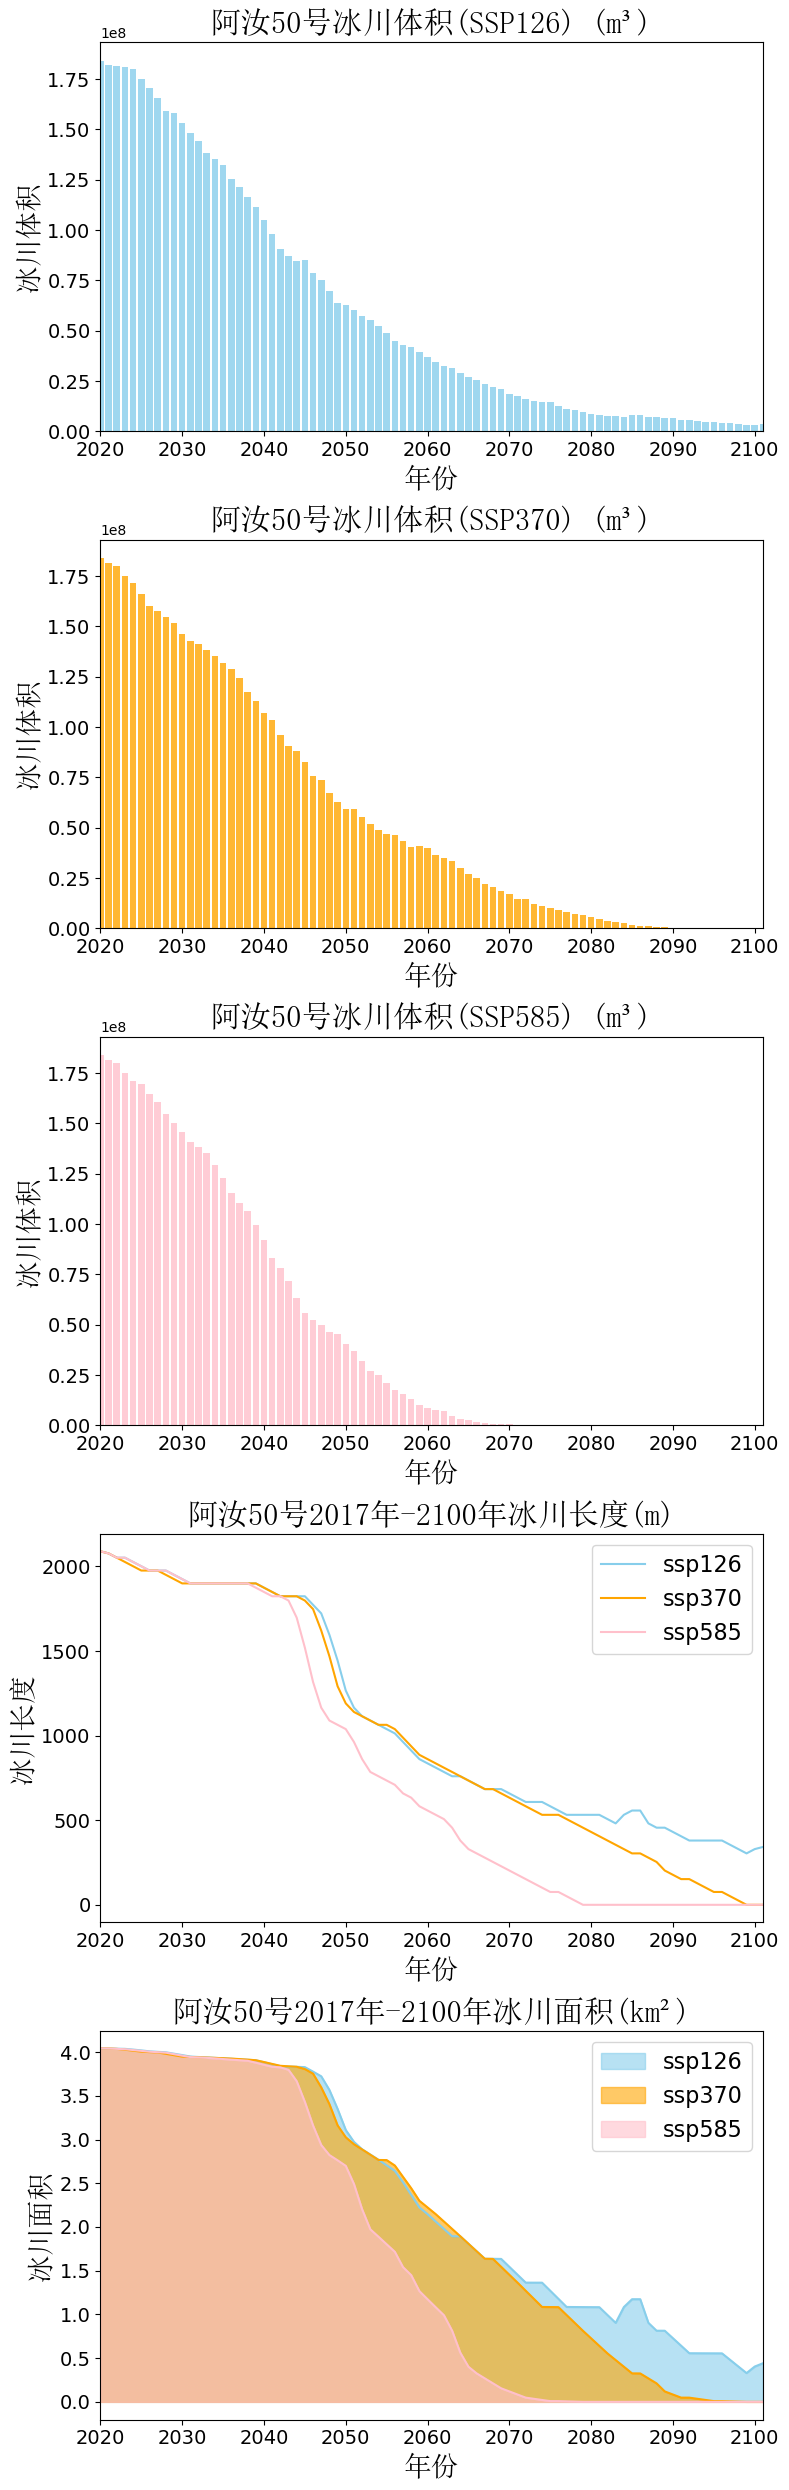

数据成功保存到：/mnt/d/lidar/projection/aru50_glacier_projection.xlsx


In [62]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import font_manager as fm

font_path = '/usr/share/fonts/simsun.ttc'
my_font = fm.FontProperties(fname=font_path)

color_dict = {'ssp126': 'skyblue', 'ssp370': 'orange', 'ssp585': 'pink'}
smooth_win = 3
ssp_list = ['ssp126', 'ssp370', 'ssp585']

f, axes = plt.subplots(5, 1, figsize=(8, 25))
(ax1, ax2, ax3, ax4, ax5) = axes  # 分配 5 个子图：3个体积 + 1长度 + 1面积

fntsize1 = 22
fntsize2 = 20

# 用于保存 DataFrame 数据
data_dict = {}

for i, ssp in enumerate(ssp_list):
    rid = f'_ISIMIP3b_{member}_{ssp}'
    with xr.open_dataset(gdir_cl.get_filepath('model_diagnostics', filesuffix=rid)) as ds:
        vol_smooth = ds.volume_m3.rolling(time=smooth_win, center=True, min_periods=1).mean()
        len_smooth = ds.length_m.rolling(time=smooth_win, center=True, min_periods=1).mean()
        area_smooth = (ds.area_m2 / 1e6).rolling(time=smooth_win, center=True, min_periods=1).mean()

        time = vol_smooth['time'].values

        # === 每个情景一个体积柱状图 ===
        ax = [ax1, ax2, ax3][i]
        ax.bar(time, ds.volume_m3.values, width=0.8, color=color_dict[ssp], alpha=0.8)
        ax.set_title(f'阿汝50号冰川体积({ssp.upper()}) (m³)', fontproperties=my_font, fontsize=fntsize1)
        ax.set_xlabel('年份', fontproperties=my_font, fontsize=fntsize2)
        ax.set_ylabel('冰川体积', fontproperties=my_font, fontsize=fntsize2)
        ax.set_xlim(time[0], time[-1])
        time1 = time[::10]
        ax.set_xticks(time1)
        ax.set_xticklabels(time1.astype(int))
        ax.tick_params(labelsize=14)

        # 保存数据
        year = pd.to_datetime(time).year
        data_dict[f'{ssp}_volume_m3'] = vol_smooth.values
        data_dict[f'{ssp}_length_m'] = len_smooth.values
        data_dict[f'{ssp}_area_km2'] = area_smooth.values

        if i == 0:
            data_dict['Year'] = year

        # === 长度图（共用一个）===
        ax4.plot(time, len_smooth.values, label=ssp, color=color_dict[ssp])
        # === 面积图（共用一个）===
        ax5.fill_between(time, 0, area_smooth.values, label=ssp,
                         color=color_dict[ssp], alpha=0.6)
        ax5.plot(time, area_smooth.values, color=color_dict[ssp])

# === 长度图设置 ===
ax4.set_title('阿汝50号2017年-2100年冰川长度(m)', fontproperties=my_font, fontsize=fntsize1)
ax4.set_xlabel('年份', fontproperties=my_font, fontsize=fntsize2)
ax4.set_ylabel('冰川长度', fontproperties=my_font, fontsize=fntsize2)
ax4.set_xlim(time[0], time[-1])
time1 = time[::10]
ax4.set_xticks(time1)
ax4.set_xticklabels(time1.astype(int))
ax4.tick_params(labelsize=14)
ax4.legend(loc='upper right', prop={'family': 'Times New Roman', 'size': 16})

# === 面积图设置 ===
ax5.set_title('阿汝50号2017年-2100年冰川面积(km²)', fontproperties=my_font, fontsize=fntsize1)
ax5.set_xlabel('年份', fontproperties=my_font, fontsize=fntsize2)
ax5.set_ylabel('冰川面积', fontproperties=my_font, fontsize=fntsize2)
ax5.set_xlim(time[0], time[-1])
ax5.set_xticks(time1)
ax5.set_xticklabels(time1.astype(int))
ax5.tick_params(labelsize=14)
ax5.legend(loc='upper right', prop={'family': 'Times New Roman', 'size': 16})

plt.tight_layout()
plt.show()

# === 保存为 Excel ===
df = pd.DataFrame(data_dict)
df = df[['Year'] + [col for col in df.columns if col != 'Year']]
output_path = r'/mnt/d/lidar/projection/aru50_glacier_projection.xlsx'
df.to_excel(output_path, index=False)
print(f"数据成功保存到：{output_path}")


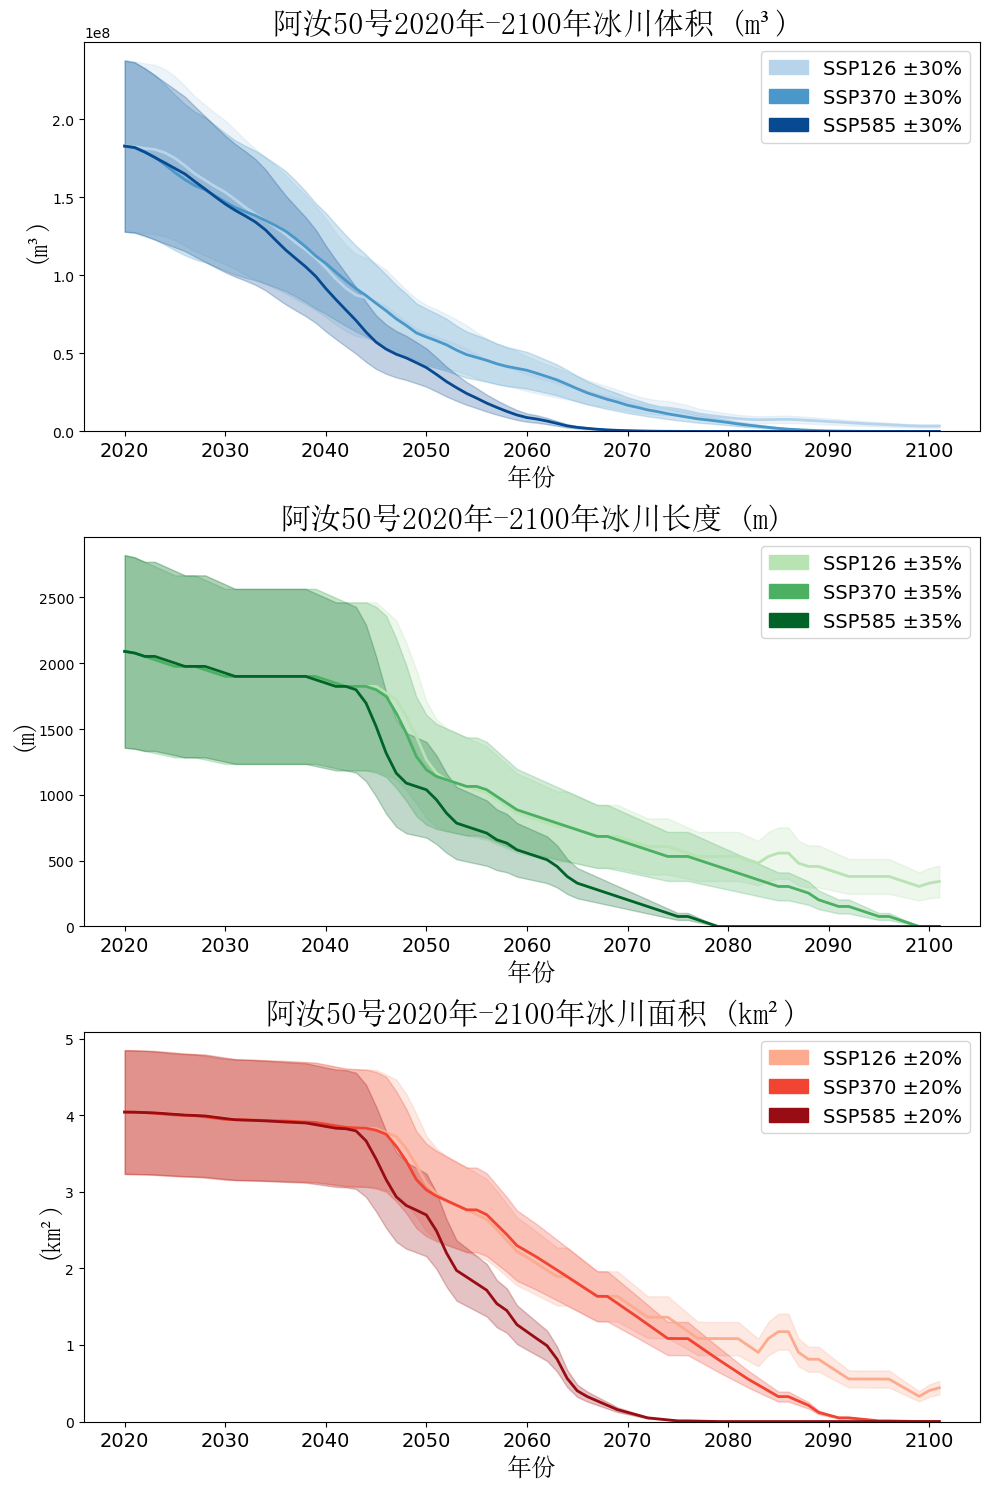

✅ 数据与分层颜色不确定性范围已保存到：/mnt/d/lidar/projection/aru50_glacier_projection_uncertainty.xlsx


In [63]:
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import font_manager as fm
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch

# ===================== 基础设置 =====================
font_path = '/usr/share/fonts/simsun.ttc'
my_font = fm.FontProperties(fname=font_path)

smooth_win = 3
ssp_list = ['ssp126', 'ssp370', 'ssp585']

# 不确定性比例
uncertainty = {
    'volume_m3': 0.30,
    'length_m': 0.35,
    'area_m2': 0.20
}

# 指标对应 colormap


cmaps = {
    'volume_m3': matplotlib.colormaps['Blues'],
    'length_m': matplotlib.colormaps['Greens'],
    'area_m2': matplotlib.colormaps['Reds']
}


f, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
titles = ['阿汝50号2020年-2100年冰川体积 (m³)',
          '阿汝50号2020年-2100年冰川长度 (m)',
          '阿汝50号2020年-2100年冰川面积 (km²)']

# ===================== 绘图部分 =====================
for i, (ax, var) in enumerate(zip(axes, ['volume_m3', 'length_m', 'area_m2'])):
    cmap = cmaps[var]
    handles = []  # 用于图例
    for j, ssp in enumerate(ssp_list):
        rid = f'_ISIMIP3b_{member}_{ssp}'
        with xr.open_dataset(gdir_cl.get_filepath('model_diagnostics', filesuffix=rid)) as ds:
            ydata = ds[var].rolling(time=smooth_win, center=True, min_periods=1).mean()
            if var == 'area_m2':
                ydata = ydata / 1e6
            time = ydata['time'].values
            yval = ydata.values

            # 颜色深浅
            color = cmap(0.3 + 0.3*j)
            unc = uncertainty[var]
            y_upper = yval * (1 + unc)
            y_lower = yval * (1 - unc)

            # 绘制主曲线与阴影
            ax.plot(time, yval, color=color, linewidth=2)
            fill = ax.fill_between(time, y_lower, y_upper, color=color, alpha=0.25)

            # 添加图例 handle
            handles.append(Patch(facecolor=color, edgecolor=color,
                                 label=f'{ssp.upper()} ±{int(unc*100)}%'))

    ax.set_title(titles[i], fontproperties=my_font, fontsize=22)
    ax.set_ylabel(titles[i].split(' ')[-1], fontproperties=my_font, fontsize=18)
    ax.set_ylim(bottom=0)
    ax.legend(handles=handles, loc='upper right', prop={'family': 'Times New Roman', 'size': 14})
    ax.set_xlabel('年份', fontproperties=my_font, fontsize=18)
    time1 = time[::10]
    ax.set_xticks(time1)
    ax.set_xticklabels(time1.astype(int), fontsize=14)
    ax.tick_params(axis='x', labelbottom=True,labelsize=14) 
# axes[-1].set_xlabel('年份', fontproperties=my_font, fontsize=18)
# time1 = time[::10]
# axes[-1].set_xticks(time1)
# axes[-1].set_xticklabels(time1.astype(int), fontsize=14)

plt.tight_layout()
plt.show()

# ===================== 导出数据部分 =====================
data_dict = {}
for ssp in ssp_list:
    rid = f'_ISIMIP3b_{member}_{ssp}'
    with xr.open_dataset(gdir_cl.get_filepath('model_diagnostics', filesuffix=rid)) as ds:
        vol_smooth = ds.volume_m3.rolling(time=smooth_win, center=True, min_periods=1).mean()
        len_smooth = ds.length_m.rolling(time=smooth_win, center=True, min_periods=1).mean()
        area_smooth = (ds.area_m2 / 1e6).rolling(time=smooth_win, center=True, min_periods=1).mean()
        time = pd.to_datetime(vol_smooth['time'].values).year

        vol_unc = uncertainty['volume_m3']
        len_unc = uncertainty['length_m']
        area_unc = uncertainty['area_m2']

        # volume
        data_dict[f'{ssp}_volume_m3'] = vol_smooth.values
        data_dict[f'{ssp}_volume_upper'] = vol_smooth.values * (1 + vol_unc)
        data_dict[f'{ssp}_volume_lower'] = vol_smooth.values * (1 - vol_unc)
        # length
        data_dict[f'{ssp}_length_m'] = len_smooth.values
        data_dict[f'{ssp}_length_upper'] = len_smooth.values * (1 + len_unc)
        data_dict[f'{ssp}_length_lower'] = len_smooth.values * (1 - len_unc)
        # area
        data_dict[f'{ssp}_area_km2'] = area_smooth.values
        data_dict[f'{ssp}_area_upper'] = area_smooth.values * (1 + area_unc)
        data_dict[f'{ssp}_area_lower'] = area_smooth.values * (1 - area_unc)

data_dict['Year'] = time
df = pd.DataFrame(data_dict)
df = df[['Year'] + [col for col in df.columns if col != 'Year']]

output_path = r'/mnt/d/lidar/projection/aru50_glacier_projection_uncertainty.xlsx'
df.to_excel(output_path, index=False)
print(f"✅ 数据与分层颜色不确定性范围已保存到：{output_path}")
